LangGraph 人机交互

### 审查工具调用

人工介入智能体的工具调用过程，实现人机协同

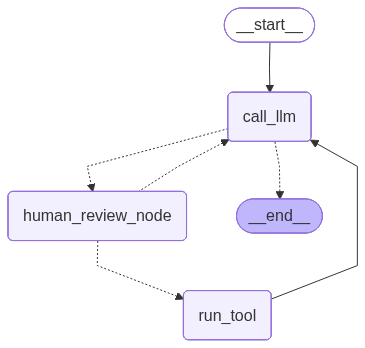

In [ ]:
import os
from typing_extensions import Literal
from langchain_deepseek import ChatDeepSeek
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command, interrupt
from langchain_core.messages import AIMessage
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv(".env", override=True)


# 定义工具
@tool
def weather_search(city):
    """用来返回天气信息的工具函数"""
    if city == "北京":
        return "北京天气晴朗 大约22度 湿度30%"
    elif city == "深圳":
        return "深圳天气多云 大约28度 湿度80%"
    else:
        return "晴"


tools = [weather_search]

model = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)
bound_model = model.bind_tools(tools)


class State(MessagesState):
    """简单状态"""


def call_llm(state: State):
    return {"messages": [bound_model.invoke(state["messages"])]}


# 人类审查节点 条件边
def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # 这是我们将通过Command(resume=<human_revire>)提供的值
    # 使用interrupt打断流
    human_review = interrupt(
        {
            "question": "这是正确的吗？",
            # 显示工具调用以供审核
            "tool_call": tool_call,
        }
    )

    # 获取人类的应答值
    review_action = human_review["action"]
    review_data = human_review.get("data")

    # 如果批准，调用工具
    if review_action == "continue":
        return Command(goto="run_tool")

    # 更新AI消息并调用工具
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # 这是人类提供的更新
                    "args": review_data,
                }
            ],
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # 向LLM提供反馈
    elif review_action == "feedback":
        # 注意：我们将反馈消息添加为ToolMessage，以保持消息历史中的正确顺序
        # （带有工具调用的AI消息需要后跟工具调用消息）
        tool_message = {
            "role": "tool",
            "name": tool_call["name"],
            "content": review_data,
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


# 工具执行节点
def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_result = tools[tool_name].invoke(tool_args)
        new_messages.append(
            {
                "role": "tool",
                "name": tool_name,
                "content": tool_result,
                "tool_call_id": tool_call["id"],
            }
        )

    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node("call_llm", call_llm)
builder.add_node("run_tool", run_tool)
builder.add_node("human_review_node", human_review_node)

builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")


# 设置内存
memory = MemorySaver()

# 添加
graph = builder.compile(checkpointer=memory)

# 查看
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# 当不涉及到工具调用时，是不会涉及人工审查的

# 输入
initial_input = {"messages": [{"role": "user", "content": "你好！"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='你好！我可以帮你查询北京或深圳的天气信息。你想了解哪个城市的天气呢？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 308, 'total_tokens': 327, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 308}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '15d9ee0e-190a-4886-aa48-7e73254fbec7', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b87b6-57f0-7040-951f-36137e4f279c-0', usage_metadata={'input_tokens': 308, 'output_tokens': 19, 'total_tokens': 327, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]}}




In [4]:
# 涉及人工调用

# 输入
initial_input = {"messages": [{"role": "user", "content": "北京的天气怎么样？"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='我来帮您查询北京的天气情况。', additional_kwargs={'tool_calls': [{'id': 'call_00_CM7OvdI4CZBBjosKvPOF2KSN', 'function': {'arguments': '{"city": "北京"}', 'name': 'weather_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 310, 'total_tokens': 360, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 54}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'a9ac4fab-5afa-44c6-8c39-f8338b9dc76b', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b87b6-9b72-7591-8957-af69504b5e01-0', tool_calls=[{'name': 'weather_search', 'args': {'city': '北京'}, 'id': 'call_00_CM7OvdI4CZBBjosKvPOF2KSN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 310, 'output_tokens': 50, 'total_tokens':

In [5]:
# 使用Command进行人工交互
for event in graph.stream(
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
    include_run_info=True,
):
    print(event)
    print("\n")

{'human_review_node': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': '北京天气晴朗 大约22度 湿度30%', 'tool_call_id': 'call_00_CM7OvdI4CZBBjosKvPOF2KSN'}]}}


{'call_llm': {'messages': [AIMessage(content='根据查询结果，北京今天的天气情况如下：\n- **天气状况**：晴朗\n- **温度**：大约22度\n- **湿度**：30%\n\n今天北京的天气很不错，晴朗舒适，温度适宜，湿度也比较适中，是个适合外出活动的好天气。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 388, 'total_tokens': 444, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 68}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '4e380da8-d7ea-486d-8ede-d397b1bd5dbc', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b87b6-cbce-7572-bf58-bfff389e5cf7-0', usage_metadata={'input_tokens': 388, 'output_tokens': 56, 'total_tokens': 444, 'inpu

In [ ]:
# 更进一步，对智能体调用的工具进行参数编辑

# 输入
initial_input = {"messages": [{"role": "user", "content": "深圳的天气怎么样？"}]}

# Thread
thread = {"configurable": {"thread_id": "3"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'call_llm': {'messages': [AIMessage(content='我来帮您查询深圳的天气情况。', additional_kwargs={'tool_calls': [{'id': 'call_00_dRzPgEbfPQFON3Nz3aLSdsmp', 'function': {'arguments': '{"city": "深圳"}', 'name': 'weather_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 311, 'total_tokens': 362, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 55}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '636d640d-e4b1-4a7c-84df-430be0e82cda', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b87b7-08f8-70f2-8301-d15cbda24e06-0', tool_calls=[{'name': 'weather_search', 'args': {'city': '深圳'}, 'id': 'call_00_dRzPgEbfPQFON3Nz3aLSdsmp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 311, 'output_tokens': 51, 'total_tokens':

In [7]:
# 直接对工具的参数进行编辑
for event in graph.stream(
    Command(resume={"action": "update", "data": {"city": "上海,中国"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'ai', 'content': '我来帮您查询深圳的天气情况。', 'tool_calls': [{'id': 'call_00_dRzPgEbfPQFON3Nz3aLSdsmp', 'name': 'weather_search', 'args': {'city': '上海,中国'}}], 'id': 'lc_run--019b87b7-08f8-70f2-8301-d15cbda24e06-0'}]}}




ValidationError: 1 validation error for weather_search
city
  Input should be '北京' or '深圳' [type=literal_error, input_value='上海,中国', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/literal_error

### 人机交互：对图状态进行编辑

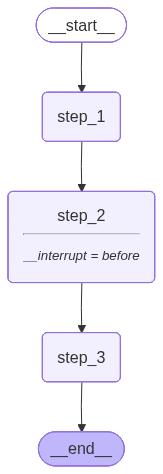

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")


def step_2(state):
    print("---Step 2---")


def step_3(state):
    print("---Step 3---")


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

memory = MemorySaver()

# interrupt_before 流运行到step_2时会中断
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# 输入
initial_input = {"input": "你好！"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)
    print("\n")

{'input': '你好！'}


---Step 1---


In [15]:
# 人工介入

graph.update_state(thread, {"input": "你好 xxxxx"})
print("--- updated state! ---")
print(graph.get_state(thread).values)

--- updated state! ---
{'input': '你好 xxxxx'}


In [16]:
# 继续执行

for event in graph.stream(None, thread, stream_mode="values"):
    print(event)
    print("\n")

{'input': '你好 xxxxx'}


---Step 2---
---Step 3---
